In [4]:
import matplotlib.pyplot as plt
import re

#### Loading the original csv file

In [8]:
import pandas as pd
df = pd.read_csv('apple_twitter_sentiment_dfe.csv')
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [9]:
df.shape

(3886, 2)

In [10]:
df.sentiment.value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

In [11]:
filtered_df = df[df['sentiment'] != 'not_relevant']
filtered_df.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [12]:
filtered_df.sentiment.value_counts()

3    2162
1    1219
5     423
Name: sentiment, dtype: int64

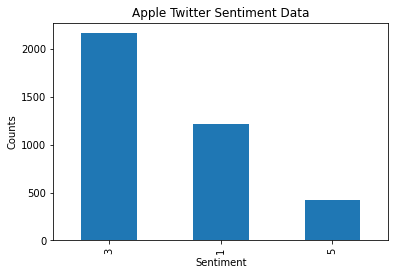

In [13]:
plt.title('Apple Twitter Sentiment Data')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
filtered_df['sentiment'].value_counts().plot(kind='bar')
plt.show()

##### preprocessing
removes @mentions, hashtag #, remove RT, removes hyperlinks

In [14]:
# Clean the tweets
def cleanText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?:\/\/\S+', '', text)
  return text

filtered_df['text'] = filtered_df['text'].apply(cleanText)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
filtered_df.head()

,text,sentiment
0,AAPL:The 10 best Steve Jobs emails ever...,3
1,: Why AAPL Stock Had a Mini-Flash Crash Today ...,3
2,My cat only chews cords. Such an AppleSnob.,3
3,I agree with that the IndividualInvestor shou...,3
4,Nobody expects the Spanish Inquisition AAPL,3


##### increasing training data with backtranslate

In [16]:
!pip install google_trans_new

In [17]:
# Import Library
import random
import torch, torchtext
from torchtext import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

#### Plan
* Divide the preprocessed text train and test
* train on this
* Augment traindata and train on this
* Compare the augmentation

In [18]:

from sklearn.model_selection import train_test_split

traindf, testdf = train_test_split(filtered_df, test_size=0.2, random_state=SEED)

In [19]:
import random
import google_trans_new

from google_trans_new import google_translator

translator = google_translator()


In [20]:
def googletranslate(text):
  tempfr = translator.translate(text, lang_tgt='de')
  return translator.translate(tempfr, lang_src='de', lang_tgt='en')

augmenting 60% of the training by using backtranslate

In [21]:
tempdf = traindf.copy()
#apply augmentation on fractin of the dataset
tempdf = tempdf.sample(frac = 0.6, random_state=SEED)
tempdf['tweets'] = tempdf['text'].apply(googletranslate)
augdf = pd.concat([traindf, tempdf], ignore_index=True)
print(traindf.shape, augdf.shape, testdf.shape)

(3043, 2) (4869, 3) (761, 2)


In [22]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [23]:
fields = [('tweets', Tweet),('labels',Label)]

##### preparing datasets with traindata, augmented train data and test data.

In [24]:
example = [data.Example.fromlist([augdf.text.iloc[i], augdf.sentiment.iloc[i]], fields) for i in range(augdf.shape[0])] 
AppleAugTrainDataset = data.Dataset(example, fields)

In [25]:
example = [data.Example.fromlist([traindf.text.iloc[i], traindf.sentiment.iloc[i]], fields) for i in range(traindf.shape[0])] 
AppleTrainDataset = data.Dataset(example, fields)

In [26]:
example = [data.Example.fromlist([testdf.text.iloc[i], testdf.sentiment.iloc[i]], fields) for i in range(testdf.shape[0])] 
AppleTestDataset = data.Dataset(example,fields)

In [27]:
(train, valid) = AppleTrainDataset, AppleTestDataset

In [28]:
len(train), len(valid)

(3043, 761)

In [29]:
vars(train.examples[10])

{'labels': '1',
 'tweets': ['Hey',
  '  ',
  'I',
  "'m",
  'not',
  'a',
  'fan',
  'of',
  'your',
  'latest',
  'commercial',
  '!',
  '!']}

In [30]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [31]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  6796
Size of label vocab :  3
Top 10 words appreared repeatedly : [(' ', 2714), ('.', 1667), ('!', 1433), ('the', 1160), (',', 1104), (':', 1079), ('to', 779), ('Apple', 695), ('AAPL', 653), ('  ', 625)]
Labels :  defaultdict(<function _default_unk_index at 0x7fa3af326840>, {'3': 0, '1': 1, '5': 2})


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

In [34]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [36]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.3

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [37]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(6796, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 2,280,703 trainable parameters


In [38]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [39]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [41]:
N_EPOCHS = 100
best_valid_loss = float('inf')
acc_values = {'train' : [], 'valid' : []}
loss_values = {'train' : [], 'valid' : []}

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    acc_values['train'].append(train_acc)
    acc_values['valid'].append(valid_acc)
    loss_values['train'].append(train_loss)
    loss_values['valid'].append(valid_loss)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch : {epoch}\n\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Epoch : 0
	Train Loss: 0.950 | Train Acc: 60.82%
	 Val. Loss: 0.872 |  Val. Acc: 68.44% 

Epoch : 1
	Train Loss: 0.826 | Train Acc: 72.72%
	 Val. Loss: 0.843 |  Val. Acc: 70.60% 

Epoch : 2
	Train Loss: 0.767 | Train Acc: 78.61%
	 Val. Loss: 0.843 |  Val. Acc: 71.03% 

Epoch : 3
	Train Loss: 0.732 | Train Acc: 82.03%
	 Val. Loss: 0.838 |  Val. Acc: 70.15% 

Epoch : 4
	Train Loss: 0.709 | Train Acc: 85.06%
	 Val. Loss: 0.837 |  Val. Acc: 69.50% 

Epoch : 5
	Train Loss: 0.687 | Train Acc: 87.21%
	 Val. Loss: 0.832 |  Val. Acc: 71.23% 

Epoch : 6
	Train Loss: 0.674 | Train Acc: 88.22%
	 Val. Loss: 0.840 |  Val. Acc: 70.24% 

Epoch : 7
	Train Loss: 0.658 | Train Acc: 89.94%
	 Val. Loss: 0.838 |  Val. Acc: 70.28% 

Epoch : 8
	Train Loss: 0.646 | Train Acc: 90.69%
	 Val. Loss: 0.843 |  Val. Acc: 69.24% 

Epoch : 9
	Train Loss: 0.640 | Train Acc: 91.31%
	 Val. Loss: 0.843 |  Val. Acc: 69.20% 

Epoch : 10
	Train Loss: 0.636 | Train Acc: 91.60%
	 Val. Loss: 0.847 |  Val. Acc: 68.94% 

Epoch : 1

In [42]:
max(acc_values['train']), max(acc_values['valid'])

(0.9401041666666666, 0.7122916653752327)

In [43]:
(train, valid) = AppleAugTrainDataset, AppleTestDataset

In [44]:
len(train), len(valid)

(4869, 761)

In [45]:
Tweet.build_vocab(train)
Label.build_vocab(train)
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  6796
Size of label vocab :  3
Top 10 words appreared repeatedly : [(' ', 4306), ('.', 2644), ('!', 2227), ('the', 1835), (',', 1746), (':', 1695), ('to', 1239), ('Apple', 1095), ('AAPL', 1023), ('  ', 979)]
Labels :  defaultdict(<function _default_unk_index at 0x7fa3af326840>, {'3': 0, '1': 1, '5': 2})


In [46]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [48]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.3

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [49]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [50]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [51]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [52]:
N_EPOCHS = 100
best_valid_loss = float('inf')
aug_acc_values = {'train' : [], 'valid' : []}
aug_loss_values = {'train' : [], 'valid' : []}

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    aug_acc_values['train'].append(train_acc)
    aug_acc_values['valid'].append(valid_acc)
    aug_loss_values['train'].append(train_loss)
    aug_loss_values['valid'].append(valid_loss)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch : {epoch}\n\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Epoch : 0
	Train Loss: 0.891 | Train Acc: 65.38%
	 Val. Loss: 0.842 |  Val. Acc: 71.29% 

Epoch : 1
	Train Loss: 0.763 | Train Acc: 78.81%
	 Val. Loss: 0.820 |  Val. Acc: 72.63% 

Epoch : 2
	Train Loss: 0.714 | Train Acc: 83.91%
	 Val. Loss: 0.815 |  Val. Acc: 72.89% 

Epoch : 3
	Train Loss: 0.674 | Train Acc: 88.17%
	 Val. Loss: 0.812 |  Val. Acc: 73.70% 

Epoch : 4
	Train Loss: 0.654 | Train Acc: 89.99%
	 Val. Loss: 0.814 |  Val. Acc: 73.18% 

Epoch : 5
	Train Loss: 0.641 | Train Acc: 91.22%
	 Val. Loss: 0.826 |  Val. Acc: 72.63% 

Epoch : 6
	Train Loss: 0.636 | Train Acc: 91.72%
	 Val. Loss: 0.808 |  Val. Acc: 74.19% 

Epoch : 7
	Train Loss: 0.629 | Train Acc: 92.22%
	 Val. Loss: 0.820 |  Val. Acc: 72.03% 

Epoch : 8
	Train Loss: 0.628 | Train Acc: 92.26%
	 Val. Loss: 0.817 |  Val. Acc: 73.20% 

Epoch : 9
	Train Loss: 0.623 | Train Acc: 92.95%
	 Val. Loss: 0.821 |  Val. Acc: 72.81% 

Epoch : 10
	Train Loss: 0.624 | Train Acc: 92.77%
	 Val. Loss: 0.827 |  Val. Acc: 71.94% 

Epoch : 1

In [55]:
max(aug_acc_values['train']), max(aug_acc_values['valid'])

(0.9499591503267973, 0.7418750002980232)

In [61]:
#Saving the augmented accuracy,loss and non_augmented accuracy loss into a json file
btexperiment = {'NoAugacc' : acc_values,
                'NoAugloss' : loss_values,
                'Augacc' : aug_acc_values,
                'Augloss' : aug_loss_values}

import json

with open('backtranslateA1.json', 'w') as f:
  json.dump(btexperiment, f, indent=2)

print('json file created successfully with accuracy and loss values.')

json file created successfully with accuracy and loss values.


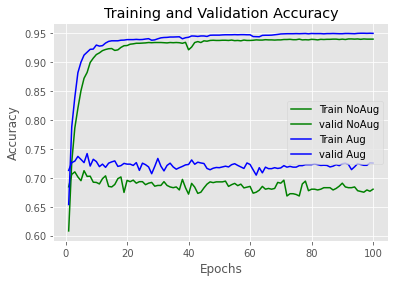

<Figure size 432x288 with 0 Axes>

In [59]:
plt.style.use("ggplot")
epochs = range(1, 101)
plt.plot(epochs, acc_values['train'], 'g', label='Train NoAug')
plt.plot(epochs, acc_values['valid'], 'g', label='valid NoAug')
plt.plot(epochs, aug_acc_values['train'], 'b', label='Train Aug')
plt.plot(epochs, aug_acc_values['valid'], 'b', label='valid Aug')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig("accuracybacktranslate.jpg")

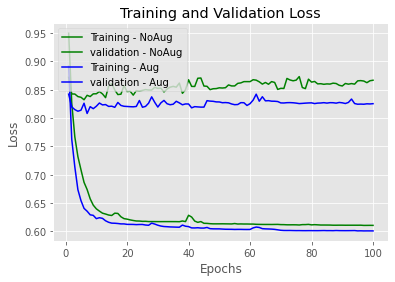

<Figure size 432x288 with 0 Axes>

In [58]:
plt.style.use("ggplot")
epochs = range(1, 101)
plt.plot(epochs, loss_values['train'], 'g', label='Training - NoAug')
plt.plot(epochs, loss_values['valid'], 'g', label='validation - NoAug')
plt.plot(epochs, aug_loss_values['train'], 'b', label='Training - Aug')
plt.plot(epochs, aug_loss_values['valid'], 'b', label='validation - Aug')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('lossbacktranslate.jpg')

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {1: "Negative", 2:"Positive", 0:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [ ]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

'Negative'